# Lab 05 - Neural networks
## Tasks
- Train a neural network to fit the MNIST dataset
- Train a neural network to fit data from the AWA photoinjector

# Set up environment

In [ ]:
%reset -f

import os
import numpy as np
import matplotlib.pyplot as plt

#matplotlib graphs will be included in your notebook, next to the code:
%matplotlib inline

#add PyTorch and TorchVision (used for cropping etc.)
import torch
import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

#cwd = os.getcwd()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

drive_directory = '/content/drive/MyDrive/optimization_and_ml/labs/lab_05_neural_networks/'
cwd = drive_directory

Mounted at /content/drive


# Load training and test data
To start with we will be training a neural network to identify handwritten numbers. The input of this neural network will be the flattened image data (28 x 28 px) from the MNIST dataset (shape is 784 x 1). The output layer is a set of 10 neurons each representing an integer from 0-9. The neurons return between 0-1 based on the likelihood that a given number is in the image.

In [ ]:
#create objects to load and pre-process the data
batch_size_train = 1024
batch_size_test = 1000

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(cwd + '/files/', train=True, download=True,
                                 transform=torchvision.transforms.Compose([
                                    torchvision.transforms.ToTensor(),
                                    torchvision.transforms.Normalize(
                                     (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(cwd + '/files/', train=False, download=True,
                                transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor(),
                                torchvision.transforms.Normalize(
                                     (0.1307,), (0.3081,))
                             ])),
    batch_size=batch_size_test, shuffle=True)


Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 14.7MB/s]


Extracting /content/drive/MyDrive/optimization_and_ml/labs/lab_05_neural_networks//files/MNIST/raw/train-images-idx3-ubyte.gz to /content/drive/MyDrive/optimization_and_ml/labs/lab_05_neural_networks//files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 535kB/s]


Extracting /content/drive/MyDrive/optimization_and_ml/labs/lab_05_neural_networks//files/MNIST/raw/train-labels-idx1-ubyte.gz to /content/drive/MyDrive/optimization_and_ml/labs/lab_05_neural_networks//files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]


Extracting /content/drive/MyDrive/optimization_and_ml/labs/lab_05_neural_networks//files/MNIST/raw/t10k-images-idx3-ubyte.gz to /content/drive/MyDrive/optimization_and_ml/labs/lab_05_neural_networks//files/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 9.08MB/s]


Extracting /content/drive/MyDrive/optimization_and_ml/labs/lab_05_neural_networks//files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /content/drive/MyDrive/optimization_and_ml/labs/lab_05_neural_networks//files/MNIST/raw



## Examine the data

torch.Size([1000, 1, 28, 28])


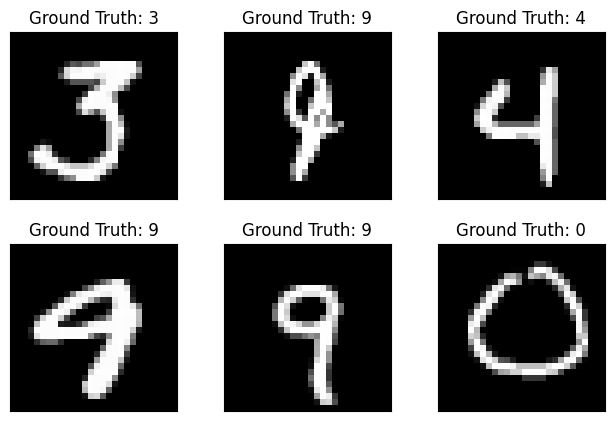

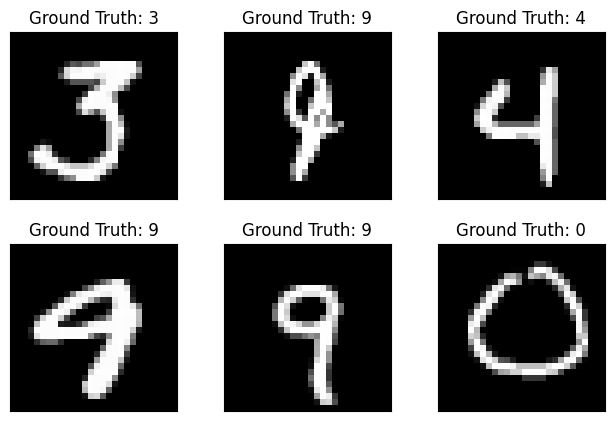

In [ ]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)

fig = plt.figure()
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
    plt.xticks([])
    plt.yticks([])
fig

# Build a Neural Network model (using fully connected layers)

In [ ]:
# we use a simple fully connected network using one hidden layer with a ReLU activation function
# the output layer is a log_softmax layer that normalizes the output such that the sum of outputs is one.
# See https://pytorch.org/docs/stable/generated/torch.nn.LogSoftmax.html for details
class NN(nn.Module):
    def __init__(self):
        super(NN, self).__init__()

        hidden_size = 20

        self.linear1 = nn.Linear(784, hidden_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(hidden_size, 10)

    def forward(self, x):
        #note that the data x is shape (batch_size, 1, 28, 28) need to reshape to flatten image -> (batch_size, 1, 784)
        x = x.view((x.shape[0], 784))

        #propagate through model
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)

        return F.log_softmax(x)

In [ ]:

learning_rate = 0.1
momentum = 0.5
log_interval = 10

fully_connected_model = NN()
optimizer = optim.SGD(fully_connected_model.parameters(), lr=learning_rate,
                      momentum=momentum)

## Train the model

### **Task:**
Insert code inside the training loop in the training function below. Then train the model and plot the loss as a function of training steps. The loss function in this case is `F.nll_loss()`.


In [ ]:
if not os.path.exists(cwd + '/results'):
    os.makedirs(cwd + '/results')

In [ ]:
def train_model(model, epochs, train_loader, optimizer):

    train_losses = []
    train_counter = []
    #set network to training mode
    model.train()
    for epoch in range(epochs):
        #iterate through data batches
        for batch_idx, (data, target) in enumerate(train_loader):

            output = model(data)
            loss = F.nll_loss(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #print out results and save to file
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*1024) + ((epoch)*len(train_loader.dataset)))
            torch.save(model.state_dict(), cwd + '/results/model.pth')
            torch.save(optimizer.state_dict(), cwd + '/results/optimizer.pth')

    return train_losses, train_counter

In [ ]:
losses, counter = train_model(model=fully_connected_model, epochs=10, train_loader=train_loader, optimizer=optimizer)

<ipython-input-8-ea4421921081>:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


Train Epoch: 0 [0/60000 (0%)]	Loss: 2.345964
Train Epoch: 0 [10240/60000 (17%)]	Loss: 0.802603
Train Epoch: 0 [20480/60000 (34%)]	Loss: 0.495634
Train Epoch: 0 [30720/60000 (51%)]	Loss: 0.412834
Train Epoch: 0 [40960/60000 (68%)]	Loss: 0.383465
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.332511
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.333537
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.301333
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.303720
Train Epoch: 1 [30720/60000 (51%)]	Loss: 0.319750
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.284900
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.308566
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.313574
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.241598
Train Epoch: 2 [20480/60000 (34%)]	Loss: 0.240465
Train Epoch: 2 [30720/60000 (51%)]	Loss: 0.271754
Train Epoch: 2 [40960/60000 (68%)]	Loss: 0.299250
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.230742
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.269089
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.287290
Train Epoch: 3 [2048

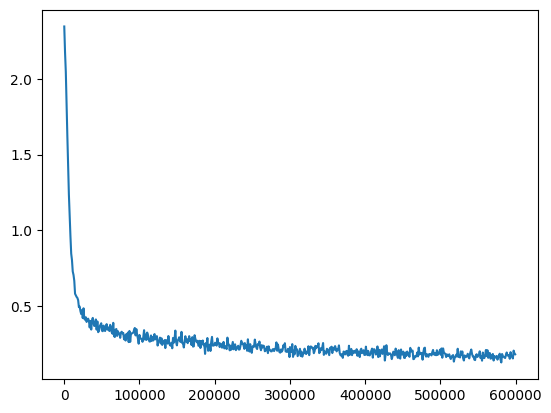

In [ ]:
plt.figure()
plt.plot(counter, losses)
plt.show()

In [ ]:
def test_model(model,loader):
    test_losses = []
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            output = model(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    return test_losses

In [ ]:
test_model(fully_connected_model, loader=test_loader)

<ipython-input-8-ea4421921081>:23: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Test set: Avg. loss: 0.0197, Accuracy: 9501/10000 (95%)



# Build model with CNN Layers
For the MNIST data set it is reasonable to use a fully connected network. If we have larger images then this scales poorly and becomes impractical quickly. Instead we can use a Convolutional neural network (CNN).

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

## Train the model

### **Task:**
Train the CNN model and plot the loss as a function of number of training examples seen.


# NN for AWA Photoinjector

### **Homework:**
    
Now its your turn! Implement and train a NN model to perform regression on data from the AWA photoinjector.
    
- The input layer should accept 7 parameters and return 6 parameters
- Start with 3 hidden layers with 20 neurons each and tanh activiation functions (since we are doing regression, not classification)
- Use the MSELoss function `torch.nn.functional.mse_loss()`

In [ ]:
#load AWA data
df = pd.read_pickle(drive_directory + 'AWA_data.pkl')
features = ['P0','P1','G0','G1','K1','K2']
targets = ['rms_x','rms_y','rms_s','emit_x','emit_y','emit_s','dE']

n_train = 70000
n_test = 30000
batch_size = 1024

#create test and train datasets
train_data = torch.utils.data.TensorDataset(torch.tensor(df.head(n_train)[features].values).float(),
                                            torch.tensor(df.head(n_train)[targets].values).float())

test_data = torch.utils.data.TensorDataset(torch.tensor(df.tail(n_test)[features].values).float(),
                                           torch.tensor(df.tail(n_test)[targets].values).float())

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)


examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_data.shape)



torch.Size([1024, 6])


In [ ]:
class AWANN(nn.Module):
    def __init__(self):
        super(AWANN, self).__init__()

        hidden_size = 40  # Number of neurons in hidden layers

        # Define layers
        self.linear1 = nn.Linear(6, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, hidden_size)
        self.linear4 = nn.Linear(hidden_size, hidden_size)
        self.linear5 = nn.Linear(hidden_size, hidden_size)
        self.linear6 = nn.Linear(hidden_size, 7)

        self.tanh = nn.Tanh()  # Activation function

    def forward(self, x):
        x = self.tanh(self.linear1(x))
        x = self.tanh(self.linear2(x))
        x = self.tanh(self.linear3(x))
        x = self.tanh(self.linear4(x))
        x = self.tanh(self.linear5(x))

        x = self.linear6(x)

        return x

In [ ]:

learning_rate = 1e-2
momentum = 0.5
log_interval = 10

awa_model = AWANN()
# optimizer = optim.SGD(awa_model.parameters(), lr=learning_rate,
#                      momentum=momentum)
optimizer = optim.Adam(awa_model.parameters(), lr=learning_rate)

In [ ]:
def train_model(model, epochs, train_loader, optimizer):
    train_losses = []
    train_counter = []
    #set network to training mode
    model.train()
    for epoch in range(epochs):
        #iterate through data batches
        for batch_idx, (data, target) in enumerate(train_loader):

            output = model(data)
            loss = F.mse_loss(output, target)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #print out results and save to file
            if batch_idx % log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                        epoch, batch_idx * len(data), len(train_loader.dataset),
                        100. * batch_idx / len(train_loader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*1024) + ((epoch)*len(train_loader.dataset)))
    return train_losses, train_counter

In [ ]:
train_losses, counter = train_model(awa_model, epochs=10, train_loader=train_loader, optimizer=optimizer)

Train Epoch: 0 [0/70000 (0%)]	Loss: 0.409197
Train Epoch: 0 [10240/70000 (14%)]	Loss: 0.035010
Train Epoch: 0 [20480/70000 (29%)]	Loss: 0.017804
Train Epoch: 0 [30720/70000 (43%)]	Loss: 0.013112
Train Epoch: 0 [40960/70000 (58%)]	Loss: 0.008811
Train Epoch: 0 [51200/70000 (72%)]	Loss: 0.006138
Train Epoch: 0 [61440/70000 (87%)]	Loss: 0.007056
Train Epoch: 1 [0/70000 (0%)]	Loss: 0.005022
Train Epoch: 1 [10240/70000 (14%)]	Loss: 0.005097
Train Epoch: 1 [20480/70000 (29%)]	Loss: 0.004122
Train Epoch: 1 [30720/70000 (43%)]	Loss: 0.002809
Train Epoch: 1 [40960/70000 (58%)]	Loss: 0.002489
Train Epoch: 1 [51200/70000 (72%)]	Loss: 0.002133
Train Epoch: 1 [61440/70000 (87%)]	Loss: 0.001965
Train Epoch: 2 [0/70000 (0%)]	Loss: 0.001643
Train Epoch: 2 [10240/70000 (14%)]	Loss: 0.001362
Train Epoch: 2 [20480/70000 (29%)]	Loss: 0.001194
Train Epoch: 2 [30720/70000 (43%)]	Loss: 0.001699
Train Epoch: 2 [40960/70000 (58%)]	Loss: 0.001071
Train Epoch: 2 [51200/70000 (72%)]	Loss: 0.001585
Train Epoch: 2 

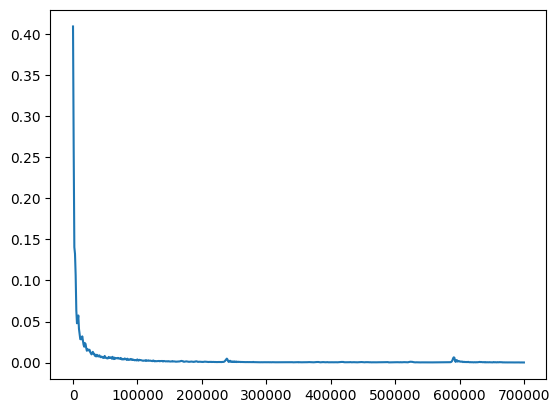

In [ ]:
plt.figure()
plt.plot(counter, train_losses)
plt.show()

In [ ]:
def test_model(model, test_loader, rtol=0.2):
    test_losses = []
    correct_predictions = 0
    total_predictions = 0
    model.eval()

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            print(f"Batch {batch_idx + 1}/{len(test_loader)}")
            output = model(data)

            # Calculate loss
            loss = F.mse_loss(output, target, reduction='mean').item()
            test_losses.append(loss)

            # Calculate accuracy (predictions within tolerance)
            # For each sample, check if all output values are within the tolerance
            correct_predictions_in_batch = (
                torch.abs(output - target) <= rtol * torch.abs(target)
            ).all(dim=1).sum().item()
            correct_predictions += correct_predictions_in_batch
            total_predictions += data.size(0)  # number of samples in the current batch

    # Calculate overall accuracy as a percentage of correct predictions
    accuracy = (correct_predictions / total_predictions) * 100

    print(f"Average MSE Loss: {sum(test_losses) / len(test_losses)}")
    print(f"Accuracy (within relative tol of {rtol}): {accuracy:.2f}%")

    return test_losses, accuracy


In [ ]:
losses, acc = test_model(awa_model, test_loader)

Batch 1/30
Batch 2/30
Batch 3/30
Batch 4/30
Batch 5/30
Batch 6/30
Batch 7/30
Batch 8/30
Batch 9/30
Batch 10/30
Batch 11/30
Batch 12/30
Batch 13/30
Batch 14/30
Batch 15/30
Batch 16/30
Batch 17/30
Batch 18/30
Batch 19/30
Batch 20/30
Batch 21/30
Batch 22/30
Batch 23/30
Batch 24/30
Batch 25/30
Batch 26/30
Batch 27/30
Batch 28/30
Batch 29/30
Batch 30/30
Average MSE Loss: 0.0002592392687802203
Accuracy (within relative tol of 0.2): 79.11%


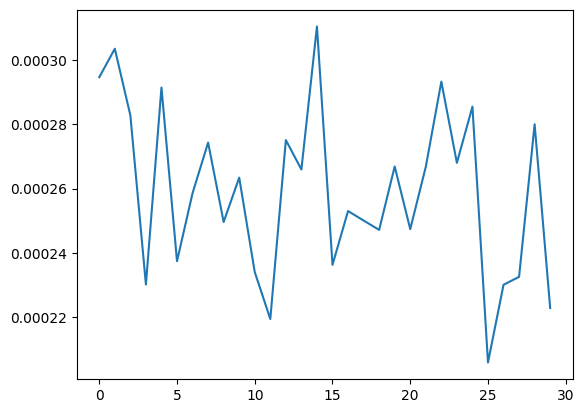

In [ ]:
plt.figure()
plt.plot(losses)